In [1]:
import getpass
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when running from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
    from LIFE_retrieval.target import Target
    from LIFE_retrieval.retrieval import Retrieval
    from LIFE_retrieval.parameters import Parameters
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from retrieval import Retrieval
    from parameters import Parameters

test_object = 'test'
Nlive=100 # number of live points (integer)
evtol=10 # evidence tolerance (float)
bayes=False

def init_retrieval(obj,Nlive,evtol,PT_type='PTgrad'):

    output=f'{obj}_N{Nlive}_e{evtol}' # output folder name
    obj = Target(obj)

    constant_params={} # add if needed
    free_params = {'rv': ([0,20],r'$v_{\rm rad}$'),
                'log_g':([1,3],r'log $g$')}
    
    if PT_type=='PTknot':
        pt_params={'T0' : ([100,1000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,1000], r'$T_1$'),
                'T2' : ([0,1000], r'$T_2$'),
                'T3' : ([0,1000], r'$T_3$'),
                'T4' : ([0,1000], r'$T_4$'),} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([0.,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([0.,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([0.,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([0.,0.4], r'$\nabla T_4$'), 
                'T0': ([100,1000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)
        
    # free chemistry, define VMRs
    chemistry={'log_H2O':([-12,0],r'log H$_2$O'),
            'log_CO':([-12,0],r'log CO'),
            'log_CO2':([-12,0],r'log CO$_2$'),
            'log_CH4':([-12,0],r'log CH$_4$'),
            'log_NH3':([-12,0],r'log NH$_3$'),
            'log_HCN':([-12,0],r'log HCN'),
            'log_H2S':([-12,0],r'log H$_2$S'),
            #'log_C2H2':([-12,n],r'log C$_2$H$_2$') # not on lem yet
            }
        
    cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
    
    free_params.update(cloud_props)
    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)
    retrieval=Retrieval(target=obj,parameters=parameters,output_name=output,PT_type=PT_type)

    return retrieval

retrieval=init_retrieval(test_object,Nlive,evtol)
#retrieval.PMN_lnL()
retrieval.run_retrieval(N_live_points=Nlive,evidence_tolerance=evtol,bayes=bayes)


ModuleNotFoundError: No module named 'LIFE_retrieval'

In [1]:
10**-0.02

0.954992586021436

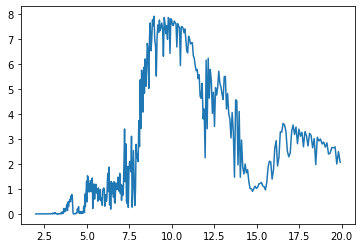

In [2]:
plt.plot(retrieval.data_wave,retrieval.data_flux)

In [7]:
retrieval.parameters.params

{'rv': 11.65007608155497,
 'log_g': 2.243707779401774,
 'dlnT_dlnP_0': 0.14531315893569174,
 'dlnT_dlnP_1': 0.1903132136337598,
 'dlnT_dlnP_2': 0.3233952083998457,
 'dlnT_dlnP_3': 0.3614994860812246,
 'dlnT_dlnP_4': 0.09496080501926643,
 'T0': 821.4114888704075,
 'log_opa_base_gray': 1.0119862622641644,
 'log_P_base_gray': -5.202428139229702,
 'fsed_gray': 15.518386400885653,
 'log_H2O': -11.068252420379599,
 'log_CO': -11.477434917487578,
 'log_CO2': -11.416189435372194,
 'log_CH4': -1.0860068266984717,
 'log_NH3': -11.512455524057632,
 'log_HCN': -11.299307592427748,
 'log_H2S': -11.44082372701107}

In [1]:
import os
import numpy as np

os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans


atm=Radtrans(line_species=['H2O_Exomol'],
                rayleigh_species = ['H2', 'He'],
                continuum_opacities = ['H2-H2', 'H2-He'],
                wlen_bords_micron=[0.3,30], 
                mode='c-k')

/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



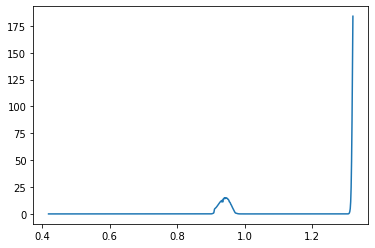

In [4]:
from pRT_model import pRT_spectrum
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

model_object=pRT_spectrum(parameters=retrieval.parameters.params,
                                     data_wave=retrieval.data_wave,
                                     target=retrieval.target,
                                     atmosphere_object=retrieval.atmosphere_object,
                                     species=retrieval.species,
                                     PT_type=retrieval.PT_type)

atmosphere=model_object.atmosphere_object
atmosphere.calc_flux(model_object.temperature,
                        model_object.mass_fractions,
                        model_object.gravity,
                        model_object.MMW)

wl = const.c.to(u.km/u.s).value/atmosphere.freq/1e-9 # mircons
flux = atmosphere.flux/np.nanmean(atmosphere.flux)
plt.plot(wl,flux)

-498.5041500586349

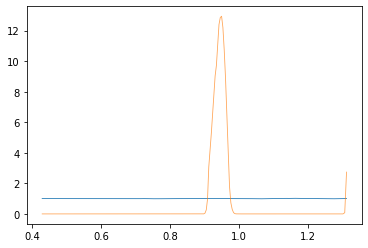

In [5]:
retrieval.PMN_lnL()

In [5]:
retrieval.parameters.params

{'rv': 17.00471481800586,
 'log_g': 1.4893212350763387,
 'dlnT_dlnP_0': 0.23251222426770954,
 'dlnT_dlnP_1': 0.12884649426141978,
 'dlnT_dlnP_2': 0.3287811970540098,
 'dlnT_dlnP_3': 0.3032677069679897,
 'dlnT_dlnP_4': 0.052503299506328066,
 'T0': 713.736923075003,
 'log_opa_base_gray': -8.690373779905903,
 'log_P_base_gray': 2.2651571204144627,
 'fsed_gray': 8.211320245511256,
 'log_H2O': -9.944677737795242,
 'log_12CO': -3.2390258734222,
 'log_CO2': -9.825592679426029,
 'log_CH4': -1.8101965433821938,
 'log_NH3': -11.252861536657159,
 'log_HCN': -6.671930488413616,
 'log_H2S': -11.665383982694642}

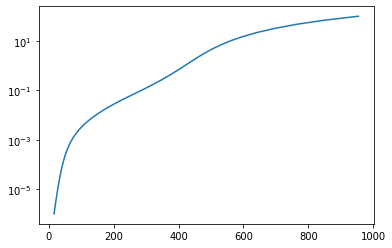

In [6]:
import matplotlib.pyplot as plt

plt.plot(retrieval.model_object.temperature,retrieval.pressure)
plt.yscale('log')

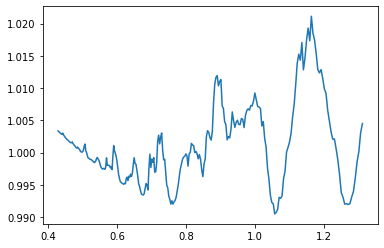

In [19]:
import matplotlib.pyplot as plt
plt.plot(retrieval.data_wave,retrieval.data_flux)
